In [1]:
from pathlib import Path
import json

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

# from mat73 import loadmat as loadmat_mat73
# from mat4py import loadmat as loadmat_mat4py

import h5py
from scipy.io import loadmat as loadmat_scipy

# Session analysis
Let's start with a session to look at the files

## Files and their description. A first take

Peter Petersen, one of the members of the Buzsaki lab, has shared with us the following documents that contain the structure of the cell explorer format:

* [new format](https://cellexplorer.org/data-structure/)
* [old format](https://github.com/buzsakilab/buzcode/wiki/Data-Formatting-Standards)

He referred to the old format as buzcode.


In [7]:
# project_root = Path("/home/heberto/buzaki/") # Heberto
project_root = Path("/Volumes/neurodata/buzaki/HuszarR") # Garrett
# project_root = Path("/shared/catalystneuro/HuszarR") # DANDI

session_path = project_root /  "optotagCA1/e13/e13_16f1/e13_16f1_210302"
assert session_path.is_dir()

# Dump to a file in the same folder
json_directory = Path.cwd() / "_json_files"
json_directory.mkdir(exist_ok=True)

# Dump project-wide information into a nested folder
project_json_directory = json_directory / "project"
project_json_directory.mkdir(exist_ok=True)

session_files_path_list = list(session_path.iterdir())
session_files_path_list

[PosixPath('/Volumes/neurodata/buzaki/HuszarR/optotagCA1/e13/e13_16f1/e13_16f1_210302/e13_16f1_210302.cell_metrics.cellinfo.mat'),
 PosixPath('/Volumes/neurodata/buzaki/HuszarR/optotagCA1/e13/e13_16f1/e13_16f1_210302/._e13_16f1_210302.cell_metrics.cellinfo.mat'),
 PosixPath('/Volumes/neurodata/buzaki/HuszarR/optotagCA1/e13/e13_16f1/e13_16f1_210302/e13_16f1_210302.ripples.events.mat'),
 PosixPath('/Volumes/neurodata/buzaki/HuszarR/optotagCA1/e13/e13_16f1/e13_16f1_210302/._e13_16f1_210302.ripples.events.mat'),
 PosixPath('/Volumes/neurodata/buzaki/HuszarR/optotagCA1/e13/e13_16f1/e13_16f1_210302/e13_16f1_210302.spikes.cellinfo.mat'),
 PosixPath('/Volumes/neurodata/buzaki/HuszarR/optotagCA1/e13/e13_16f1/e13_16f1_210302/._e13_16f1_210302.spikes.cellinfo.mat'),
 PosixPath('/Volumes/neurodata/buzaki/HuszarR/optotagCA1/e13/e13_16f1/e13_16f1_210302/e13_16f1_210302.mono_res.cellinfo.mat'),
 PosixPath('/Volumes/neurodata/buzaki/HuszarR/optotagCA1/e13/e13_16f1/e13_16f1_210302/._e13_16f1_210302.mon

Now as Cody mention, we have seen some experimental data from this lab already and we are familiar with the names.

In a [previous conversion](https://github.com/catalystneuro/buzsaki-lab-to-nwb/blob/master/buzsaki_lab_to_nwb/yuta_visual_cortex/files_documentation.ipynb) I found out that the matlab files contain the following information:



* `SleepState.states` : This can be considered processed data involving up-down intervals. This can be include as process data.
* `chanMap` : This seems to be concerned with information of the channels in the electrode. For example we find both the x and y coordinates of each of the channels. The structure of the files here is (1, n_channels) where n_channels is 64 for this setup.
* `session` : Contains behavioral info and general information related to the session such as the experimenter, the species, the strain and timestamps for the creation of the session.

As you see, we have the following descriptions missing:
* `.ripples.events.mat`: 
* `Behavior` : 

Which is something that we would do below.

#### Spike sorting
The files related to spike sorting were the following in a previous conversion.

For the previous conversion those were the files related to **cell explorer format / interface**:
* `metric_cell_info`
* `mono_res_cellinfo`
* `spikes.cell_info`

They don't seem equivalent to the ones here. We need to confirm that they are equivalent to the following files in this conversion:
* `cell_metrics.cellinfo.mat`
* `cell_metrics.cellinfo`
* `spikes.cellinfo`

This is done below.

Apparently, mono_res means Monosynaptic connections.



## Exploring some files



### `SleepState.states`

Let's now see now which matlab file opener works best

In [8]:
file_path = session_files_path_list[0]
file_path = file_path.parent / "e13_16f1_210302.SleepState.states.mat"
# Open file_path with loadmat_scipy from scipy
mat_file = loadmat_scipy(file_path, simplify_cells=True)
# Iterate over the keys and print the type of the values
for key in mat_file.keys():
    print(key, type(mat_file[key]))

print(mat_file['SleepState']['idx']['timestamps'])

__header__ <class 'bytes'>
__version__ <class 'str'>
__globals__ <class 'list'>
SleepState <class 'dict'>
[    1     2     3 ... 21004 21005 21006]


This is a recursive structure. Let's print the keys, types and shapes (if numpy array) for exploration

In [9]:
def build_keys_and_types(dictionary):
    output_dict = {}
    for key, value in dictionary.items():
        if isinstance(value, dict):
            output_dict[key] = build_keys_and_types(value)
        elif isinstance(value, np.ndarray):
            if value.size > 10:
                output_dict[key] = {
                    'type': str(type(value)),
                    'shape': str(value.shape)
                }
            else:
                # Print small arrays
                output_dict[key] = {
                    'type': str(type(value)),
                    'value': str(value)
                }
        elif isinstance(value, list):
            if len(value) > 10:
                output_dict[key] = {
                    'type': str(type(value)),
                    'length': len(value)
                }
            else:
                # Print small lists
                output_dict[key] = {
                    'type': str(type(value)),
                    'value': str(value)
                }
        else:
            output_dict[key] = {
                "type": str(type(value)),
                "value": str(value),
            }
    return output_dict

# Define your sleep_state_dict here

result = build_keys_and_types(mat_file)
json_output = json.dumps(result, indent=2)

with open(json_directory / 'sleep_state_dict.json', 'w') as f:
    f.write(json_output)
    

If you have a matlab licence, you can also just explore the file there. There are two things to look for, large arrays that might
correspond to behavorial data and metadata from the experiment.

Because I know the data from this lab I will be looking for the REM state.



In [ ]:
sleep_state_dict = mat_file["SleepState"]
json_dict = json.dumps(build_keys_and_types(sleep_state_dict), indent=4)

In [ ]:
sleep_state_dict["ints"]


In [ ]:
wake_state = sleep_state_dict["ints"]["WAKEstate"]
wake_state  # This is the start time and the end time of the wake state. Probably in frames.

So, we need to confirm the units and this can go as a `TimeIntervals` in a processing module

In [ ]:
statenames = sleep_state_dict["idx"]["statenames"]
timestamps = sleep_state_dict["idx"]["timestamps"]
states = sleep_state_dict["idx"]["states"]

states[:5], timestamps[:5], statenames[:5]

In [ ]:
wake_state = sleep_state_dict["ints"]["WAKEstate"]
wake_state[:]

In [ ]:
states[1803:1810], timestamps[1803:1810]

It apperas to me that the information coincides but the unit of the timestamps are in frames and not in seconds. We need to confirm this.

Another possibility is that they are seconds. Let's think this through

In [ ]:
timestamps[-10:]

Last timestamps is 21006 which would indicate that the recording is 21006 seconds long. This is 5.8 hours. We can check on the paper if this is the case.

### `Behavior`

In [10]:
file_path = file_path.parent / "e13_16f1_210302.Behavior.mat" 
file_path.is_file()

True

In [11]:
mat_file = loadmat_scipy(file_path, simplify_cells=True)

# Output to an external file
with open(json_directory / 'behavior_dict.json', 'w') as f:
    f.write(json.dumps(build_keys_and_types(mat_file), indent=4))

Importantly this contains a date in `date` and subject information in `animal`.
Surprisingly, this does not seem to contain any large vector as I expected

#### 8 maze task

In [12]:
timestamps = mat_file["behavior"]["timestamps"]
position = mat_file["behavior"]["position"]
lin = position["lin"]
x = position["x"]
y = position["y"]

timestamps.shape, lin.shape, x.shape, y.shape

((120838,), (120838,), (120838,), (120838,))

In [11]:
mat_file["behavior"]["description"]

'alternation'

Plotting the figure looks like and 8 maze with the dimensions that match the 60 x 60 cm in the paper

In [14]:
trials = mat_file["behavior"]["trials"]
trials['choice']

array([nan,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.])

In [32]:
def isNaN(num):
    return num!= num

def to_direction(arr):
    output = []
    for value in arr:

        if (isNaN(value)):
            output.append('timeout')
        
        elif (value == 0):
            output.append('right')

        else:
            output.append('left')

    return output

to_direction(trials['choice'])

['none',
 'right',
 'left',
 'right',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'left',
 'right',
 'right',
 'left',
 'left',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right']

In [15]:
trials["trial_ints"]

array([[ 9682.24053333,  9730.1194    ],
       [ 9731.3864    ,  9911.7989    ],
       [ 9912.73246667,  9972.68103333],
       [ 9978.6492    , 10092.8448    ],
       [10096.5124    , 10216.60953333],
       [10236.51456667, 10335.20623333],
       [10340.37423333, 10481.07656667],
       [10488.47843333, 10581.20193333],
       [10582.00213333, 10700.7989    ],
       [10715.13586667, 10916.2202    ],
       [10920.12116667, 11124.1729    ],
       [11143.11103333, 11369.90186667],
       [11382.10496667, 11584.68963333],
       [11586.35673333, 11818.98236667],
       [11819.4158    , 12071.3797    ],
       [12083.24936667, 12304.97223333],
       [12307.93966667, 12481.81706667],
       [12485.48466667, 12684.035     ],
       [12684.9019    , 12848.44336667],
       [12862.2802    , 13250.41193333],
       [13251.31216667, 13439.19313333],
       [13440.09336667, 13682.4548    ]])

In [27]:
def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

find_indices(timestamps, lambda e: e > 9972.68103333) #,  9972.68103333)

[9061,
 9062,
 9063,
 9064,
 9065,
 9066,
 9067,
 9068,
 9069,
 9070,
 9071,
 9072,
 9073,
 9074,
 9075,
 9076,
 9077,
 9078,
 9079,
 9080,
 9081,
 9082,
 9083,
 9084,
 9085,
 9086,
 9087,
 9088,
 9089,
 9090,
 9091,
 9092,
 9093,
 9094,
 9095,
 9096,
 9097,
 9098,
 9099,
 9100,
 9101,
 9102,
 9103,
 9104,
 9105,
 9106,
 9107,
 9108,
 9109,
 9110,
 9111,
 9112,
 9113,
 9114,
 9115,
 9116,
 9117,
 9118,
 9119,
 9120,
 9121,
 9122,
 9123,
 9124,
 9125,
 9126,
 9127,
 9128,
 9129,
 9130,
 9131,
 9132,
 9133,
 9134,
 9135,
 9136,
 9137,
 9138,
 9139,
 9140,
 9141,
 9142,
 9143,
 9144,
 9145,
 9146,
 9147,
 9148,
 9149,
 9150,
 9151,
 9152,
 9153,
 9154,
 9155,
 9156,
 9157,
 9158,
 9159,
 9160,
 9161,
 9162,
 9163,
 9164,
 9165,
 9166,
 9167,
 9168,
 9169,
 9170,
 9171,
 9172,
 9173,
 9174,
 9175,
 9176,
 9177,
 9178,
 9179,
 9180,
 9181,
 9182,
 9183,
 9184,
 9185,
 9186,
 9187,
 9188,
 9189,
 9190,
 9191,
 9192,
 9193,
 9194,
 9195,
 9196,
 9197,
 9198,
 9199,
 9200,
 9201,
 9202,
 9203,

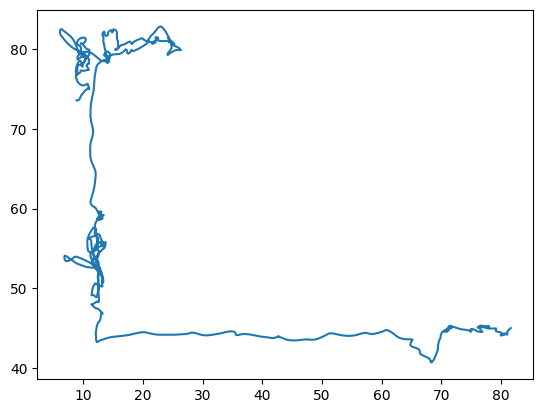

In [29]:
plt.plot(x[1824:3000], y[1824:3000])

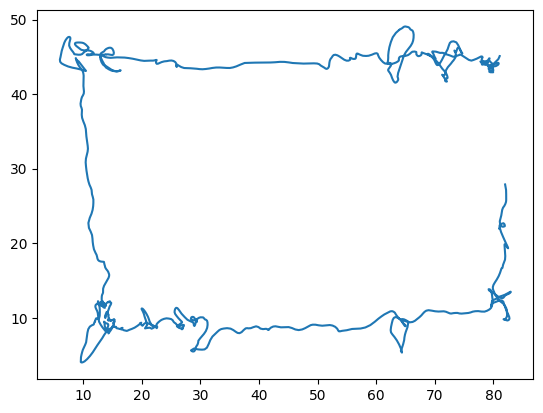

In [28]:
plt.plot(x[7264:9061], y[7264:9061])

In [ ]:
timestamps[:5]

The attributes on maps though seems to map the times to something else. I am not sure yet what

In [ ]:
mat_file["behavior"]["maps"][0]

In [ ]:
mat_file["behavior"]["maps"][1]

Importantly the timestamps do not start at 0. We need to figure this out.

In [ ]:
plt.plot(timestamps, lin)

I think this is the trajectory looked as linearly, as that matches with the lenght of the task 205 as described in the paper.

#### Trials

In [ ]:
trials = mat_file["behavior"]["trials"]
trials['choice']

In [ ]:
trials["trial_ints"]

In [ ]:
trials["endDelay"]

In [ ]:
trials["startPoint"]

In [ ]:
trials["recorings"]

#### Events

In [ ]:
events = mat_file["behavior"]["events"]
events.keys()

In [ ]:
events["rReward"]

### `ripples.events.mat`

In [ ]:
file_path = session_files_path_list[0]
file_path = file_path.parent / "e13_16f1_210302.ripples.events.mat"
file_path.is_file()

In [ ]:
mat_file = loadmat_scipy(file_path, simplify_cells=True)

# Output to an external file
with open(json_directory / 'riples.json', 'w') as f:
    f.write(json.dumps(build_keys_and_types(mat_file), indent=4))

In [ ]:
mat_file['ripples']['timestamps']

This is a large file. We need to look into the paper to see what should be stored from here

### `chanMap.mat`

In [ ]:
file_path = session_files_path_list[0]
file_path = file_path.parent / "chanMap.mat"
file_path.is_file()


In [ ]:
# Write this to a file for visualization
with open(json_directory / 'chanMap.json', 'w') as f:
    f.write(json.dumps(build_keys_and_types(mat_file), indent=4))

In [ ]:
mat_file = loadmat_scipy(file_path, simplify_cells=True)

colors = {2: "red", 1: "blue", 3: "green", 4: "yellow"}
colors_for_k_cores = [colors[int(k)] for k in mat_file["kcoords"]]

plt.scatter(mat_file["xcoords"][:], mat_file["ycoords"][:], color=colors_for_k_cores)

In [ ]:
mat_file["side"]
colors_for_back = {"Front": "red", "Back": "blue"}

colors_for_k_cores = [colors_for_back[k] for k in mat_file["side"]]


plt.scatter(mat_file["xcoords"][:], mat_file["ycoords"][:], color=colors_for_k_cores)

There are some time series here but no information about the channels as I was expecting.

### `Session`

In [ ]:
file_path = session_files_path_list[0]
file_path = file_path.parent / "e13_16f1_210302.session.mat"
file_path.is_file()


In [ ]:
mat_file = loadmat_scipy(file_path, simplify_cells=True)

# Output to an external file
with open(json_directory / 'session.json', 'w') as f:
    f.write(json.dumps(build_keys_and_types(mat_file), indent=4))

This contains useful information like subject, animal and an epoch file.
Probably less relevant is information about other sources of data such as spikesorting and some of the analogous channels.

# Spikesorting 

## Testing CellExplorer

In [ ]:
from spikeinterface.extractors import CellExplorerSortingExtractor

file_path = session_files_path_list[0].parent / "e13_16f1_210302.spikes.cellinfo.mat"
try:
    extractor = CellExplorerSortingExtractor(file_path)
except Exception as e:
    print(e)

No `sessionInfo` for this file so the above throws an assertion. Let's see what each of the files.

The `CellExplorerSortingExtractor` uses the `sessionInfo` to extract the sampling frequency. But that might be somehwere else. 

Importantly, the files should contain the fields `UID` and `times` in a field called `spikes`. Let's see if any of the files contain this information and if it is consistent across them

After a second look and some comunication with Petersen it seems that we can use the `spikes.cellinfo` file. We can modify the `CellExplorerSortingExtractor` to use this file instead of the `sessionInfo` file to extract sampling rate.

## Individual spike files

### `spikes.cellinfo.mat`

In [ ]:
file_path = session_files_path_list[0].parent / "e13_16f1_210302.spikes.cellinfo.mat"

mat_file = loadmat_scipy(file_path, simplify_cells=True)

# Output to an external file
with open(json_directory / 'spikes.cellinfo.json', 'w') as f:
    f.write(json.dumps(build_keys_and_types(mat_file), indent=4))

In [ ]:
spikes = mat_file["spikes"]
spikes.keys()

In [ ]:
sampling_rate = spikes["sr"]
cluster_id = spikes["cluID"]
times = spikes["times"]
unit_ids = spikes["UID"]

sampling_rate, cluster_id.shape, times.shape, unit_ids.shape, unit_ids[:3], cluster_id[:3], times[:3][0][:3]


### `cell_metrics.cellinfo.mat`

In [ ]:
file_path = session_files_path_list[0].parent / "e13_16f1_210302.cell_metrics.cellinfo.mat"
mat_file = loadmat_scipy(file_path, simplify_cells=True)

# Ouput to an external file
with open(json_directory / 'cell_metrics.cellinfo.json', 'w') as f:
    f.write(json.dumps(build_keys_and_types(mat_file), indent=4))

In [ ]:
times = mat_file["cell_metrics"]["spikes"]["times"]
unit_ids = mat_file["cell_metrics"]["UID"]
unit_ids = mat_file["cell_metrics"]["cluID"]
sampling_rate = None 

sampling_rate, cluster_id.shape, times.shape, unit_ids.shape, unit_ids[:3], cluster_id[:3], times[:3][0][:3]


### `mono_ress.cellinfo.mat`

In [ ]:
file_path = session_files_path_list[0].parent / "e13_16f1_210302.mono_res.cellinfo.mat"
mat_file = loadmat_scipy(file_path, simplify_cells=True)

# Output to an external file
with open(json_directory / 'mono_res.json', 'w') as f:
    f.write(json.dumps(build_keys_and_types(mat_file), indent=4))
    


This is somet other analysis concerning `Monosynaptic connections.`

## Using cellexplorer with `spikes.cellinfo.mat`

In [ ]:
from spikeinterface.extractors import CellExplorerSortingExtractor

file_path = session_files_path_list[0].parent / "e13_16f1_210302.spikes.cellinfo.mat"

try:
    extractor = CellExplorerSortingExtractor(file_path, sampling_frequency=30_000.0)
except Exception as e:
    print(e)

## Check for Consistency across Files
The following code will loop over all the folders contained in a given directory and track where they occur. This will give us an indication of the file *structure* consistency—which we can also use to detect whether the data in those files is homogeneous as well.

In [ ]:
import os
from tqdm.notebook import tqdm

def aggregate_file_info(parent_folder, func, aggregator=None):
    
    if aggregator is None:
       aggregator = []


    naming_conventions = {}
    # for root, dirs, files in tqdm(os.walk(parent_folder)):
    #     for file in tqdm(files):
    for root, dirs, files in os.walk(parent_folder):
        for file in files:
            filename, ext = os.path.splitext(file)
            # if filename and filename[0] != '.':
            if filename:
                if (filename[0] == '.'): 
                    filename = filename[1:]
                split_path = filename.split('.')
                naming_convention = '.'.join(split_path[1:]) if len(split_path) > 1 else filename # Remove the '.' character
                if naming_convention not in naming_conventions:
                    naming_conventions[naming_convention] = [] if (isinstance(aggregator, list)) else {} # Use aggregator type as a base
                
                info = func(
                    file = file,
                    naming_convention = naming_convention,
                    root = root,
                    parent_folder = parent_folder
                )

                if isinstance(naming_conventions[naming_convention], list):
                    naming_conventions[naming_convention].append(info)

                else: 
                    naming_conventions[naming_convention][file] = info
                    
    return naming_conventions

def get_file_name(root, parent_folder, **kwargs):
    return os.path.relpath(root, parent_folder)

def count_file_naming_conventions(parent_folder):
    return aggregate_file_info(parent_folder, get_file_name)

## How to extract the sampling rate

In [ ]:
spikes_matfile_path = file_path
import scipy 
import hdf5storage

try:
    spikes_mat = scipy.io.loadmat(file_name=str(spikes_matfile_path))
    read_spikes_info_with_scipy = True
except NotImplementedError:
    spikes_mat = hdf5storage.loadmat(file_name=str(spikes_matfile_path))
    read_spikes_info_with_scipy = False
cell_info = spikes_mat.get("spikes", np.empty(0))
cell_info_fields = cell_info.dtype.names

sampling_rate = float(cell_info["sr"][0][0][0][0])

### Organize Project Structure by File Types

In [ ]:
structure = count_file_naming_conventions(project_root)
with open(project_json_directory / 'structure.json', 'w') as f:
    f.write(json.dumps(structure, indent=4))

### Check for Missing File Types

In [ ]:
def add_unique_entries(arr1, arr2):
    for item in arr1:
        if item not in arr2:
            arr2.append(item)

def filter_list(original_list, filter_list):
    return [value for value in original_list if value not in filter_list]

def check_missing_files(dictionary):
    lengths = {}
    files = []
    for key, value in dictionary.items():
        lengths[key] = len(value)
        add_unique_entries(value, files)
    
    missing = dict()
    for filetype, length in lengths.items():
        if (len(files) != length):
            original_list = dictionary[filetype]
            missing[filetype] = filter_list(files, original_list)

    if len(missing.values()):
        print('This dataset has some missing files')
        
    return missing

In [ ]:
missing = check_missing_files(structure)
with open(project_json_directory / 'missing_files.json', 'w') as f:
    f.write(json.dumps(missing, indent=4))

### Aggregate Data from Files

In [ ]:
def get_file_data(file, root, **kwargs):
    filename, ext = os.path.splitext(file_path)
    if (ext == '.mat'):
        try:
            mat_file = loadmat_scipy(Path(root, file), simplify_cells=True)
            return build_keys_and_types(mat_file)
        except: 
            print(f'{file} is not readable by loadmat_scipy')

    else:
        print(f'Cannot handle {file} file type')
        
    return {}
        
def aggregate_data(parent_folder):
    return aggregate_file_info(parent_folder, get_file_data, {})

#### Register all the data associated with a project

In [ ]:
data = aggregate_data(project_root)
with open(project_json_directory / 'data.json', 'w') as f:
    f.write(json.dumps(data, indent=4))

#### Use the saved data to compare across sessions

In [ ]:
with open(project_json_directory / 'data.json') as user_file:
  file_contents = user_file.read()
  
project_data_json = json.loads(file_contents)


In [ ]:
def check_consistency(data, user_check_function, base = ''):
    expected_props = set()
    inconsistencies = {}

    # Loop through objects to discover expected properties
    for k, obj in data.items():
        props = set(obj.keys())
        expected_props = expected_props.union(props)

    # Check objects for inconsistencies
    registered_nested_properties = set()
    for file, obj in data.items():

        inconsistent_props = user_check_function(obj, expected_props, base)
        if (inconsistent_props and len(inconsistent_props)):
            inconsistencies[file] = { f'{base}.{key}': message for key, message in inconsistent_props.items() }
            # inconsistencies[file] = [ f'{base}.{key}' if base else key for key, message in inconsistent_props.items() ]

        else:
            for key in obj.keys():
                if isinstance(obj[key], dict):
                    registered_nested_properties.add(key)

    if (len(registered_nested_properties)):
        properties = {}
        for key in registered_nested_properties:
            nested_property_object = { file: obj[key] for file, obj in data.items() if obj.get(key) }
            nested_inconsistencies = check_consistency(nested_property_object, user_check_function, f'{base}.{key}' if base else key)

            if (len(nested_inconsistencies)):
                properties[key] = nested_inconsistencies

        if (len(properties)): 
            
            for key, value in properties.items():
                for file, item in value.items():
                    if (file not in inconsistencies):
                        inconsistencies[file] = {}

                    inconsistencies[file].update(item) #f'{base}.{item_string}' if base else item_string)

    return inconsistencies



def check_missing_props(parent, expected_props, base):
        # Check if any properties are missing or have inconsistent values
        props = set(parent.keys())
        
        if props != expected_props:
            missing_props = expected_props - props

            if missing_props:
                return { key: 'Missing' for key in missing_props }


# inconsistencies = { key: check_consistency(data, check_missing_props) for key, data in project_data_json.items() }

first_key = next(iter(project_data_json))
print(project_data_json[first_key].keys())
inconsistencies = { key: check_consistency(project_data_json[first_key], check_missing_props) for key, data in project_data_json.items() }

with open(project_json_directory / 'data_inconsistencies.json', 'w') as f:
    f.write(json.dumps( 
        { key: data for key, data in inconsistencies.items() if len(data) } , indent=4))
    